# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import mixedlm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from semopy import Model
from semopy.inspector import inspect
np.random.seed(1)

In [26]:
final_profile = pd.read_csv('./data/user_cluster_final.csv', sep=';')
df_sampled_ts = pd.read_csv('./data/final_sampled_v2.csv', sep=';')
df_date_time = pd.read_csv('./data/final_daily_v2.csv', sep=';')
daily_nutrition_summary = pd.read_csv('./data/daily_nutrition_summary.csv', sep=';')


In [27]:
df_sampled_ts.rename(columns={'social_date': 'date'}, inplace=True)
df_sampled_ts['date'] = pd.to_datetime(df_sampled_ts['date'])
df_sampled_ts['day_of_week'] = df_sampled_ts['date'].dt.dayofweek


In [29]:
user_profile = final_profile.merge(df_sampled_ts.groupby('id').first()[['department','cohort','degree']], left_on='id', right_on='id', how='left', suffixes=(False, False))

In [30]:
# mapping the activity columns to their ordinal values

def compute_activity_score(df):
    activity_encoding = {
        'sport_Walking, Trekking, and hiking': 2,
        'sport_Jogging and running': 6,
        'sport_Cycling, skiing, and skating': 5,
        'sport_Ball games': 7,
        'sport_Gymnastics and fitness': 3,
        'sport_Water sports': 4,
        'sport_Other indoor activities': 1,
        'sport_Other outdoor activities': 8,
    }

    activity_columns = [f"{activity}" for activity in activity_encoding.keys()]


    weights = list(activity_encoding.values())

    return df[activity_columns].dot(weights)


In [31]:
df_sampled_ts['activity_score'] = compute_activity_score(df_sampled_ts)

In [32]:
time_invariant_columns = ['id',
                    # 'department',
                    'cohort','degree', # demographic
                    # 'extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 'openness', # big5
                    'diversity_index','low_intensity', 'moderate_intensity', 'high_intensity', 'total_activities',
                    'breakfast', 'morning_snack', 'lunch',
                    'afternoon_snack', 'dinner', 'late_snack', 'avg_eating_window', 'NDS_user_mean',
                    'overall_consistency', 'kmeans_cluster'
                    ]
time_varying_columns = [
                    'id',
                    'date',
                    'day_of_week', # weekday
                    
                    'energy_gain', 'water_gain', 'protein_gain', 'fat_gain', 'carb_gain', 'fibre_gain', # nutrition
                    'alcohol', # significant alcohol consumption
                    
                    # sport activities
                    'activity_score',
                    'sleep', 
]

In [33]:
df_time_variant = df_sampled_ts[time_varying_columns].copy()
df_time_variant = df_time_variant[df_time_variant.id.isin(user_profile.id.unique())]


In [34]:
df_time_variant.columns

Index(['id', 'date', 'day_of_week', 'energy_gain', 'water_gain',
       'protein_gain', 'fat_gain', 'carb_gain', 'fibre_gain', 'alcohol',
       'activity_score', 'sleep'],
      dtype='object')

In [35]:
def process_sleep_imputation(df):
    dataframe = df.copy()
    # Convert date to datetime if not already
    dataframe['date'] = pd.to_datetime(dataframe['date'])
    dataframe['day'] = dataframe['date'].dt.date

    # Helper function to process each ID group
    def process_id_group(group):
        # Group by day and take the mean sleep value for each day
        daily_sleep = group.groupby('day')['sleep'].mean()
        
        # Create date range for this specific ID
        all_days = pd.date_range(start=group['day'].min(), end=group['day'].max(), freq='D').date
        
        # Reindex to all days in range and interpolate missing values
        sleep_series = daily_sleep.reindex(all_days)
        sleep_series_interpolated = sleep_series.interpolate(method='linear', limit_direction='both')
        
        # Map interpolated values back to original group
        group['sleep_filled'] = group['day'].map(sleep_series_interpolated)
        return group

    # Apply processing to each ID group
    dataframe = dataframe.groupby('id').apply(process_id_group).reset_index(drop=True)
    
    return dataframe['sleep_filled']

df_time_variant['sleep'] = process_sleep_imputation(df_time_variant)


In [36]:
df_time_variant.head(4).to_dict()

{'id': {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0},
 'date': {0: Timestamp('2020-11-12 19:00:00'),
  1: Timestamp('2020-11-12 19:30:00'),
  2: Timestamp('2020-11-12 20:00:00'),
  3: Timestamp('2020-11-12 20:30:00')},
 'day_of_week': {0: 3, 1: 3, 2: 3, 3: 3},
 'energy_gain': {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0},
 'water_gain': {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0},
 'protein_gain': {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0},
 'fat_gain': {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0},
 'carb_gain': {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0},
 'fibre_gain': {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0},
 'alcohol': {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0},
 'activity_score': {0: 0, 1: 0, 2: 0, 3: 0},
 'sleep': {0: 4.0, 1: 4.0, 2: 4.0, 3: 4.0}}

In [37]:
df_time_variant.id.nunique()   


143

In [38]:
user_profile.columns

Index(['id', 'diversity_index', 'low_intensity', 'moderate_intensity',
       'high_intensity', 'total_activities', 'avg_macros_energy_gain',
       'avg_macros_protein_gain', 'avg_macros_fat_gain',
       'avg_macros_carb_gain', 'avg_macros_fibre_gain',
       'macro_ratios_protein_ratio', 'macro_ratios_fat_ratio',
       'macro_ratios_carb_ratio', 'breakfast', 'morning_snack', 'lunch',
       'afternoon_snack', 'dinner', 'late_snack', 'avg_eating_window',
       'total_eating_occasions', 'NDS_user_mean', 'days_used',
       'overall_consistency', 'NDS_daily_cv', 'protein_gain_cv',
       'fibre_gain_cv', 'carb_gain_cv', 'fat_gain_cv', 'PCA1', 'PCA2',
       'kmeans_cluster', 'department', 'cohort', 'degree'],
      dtype='object')

In [39]:
# Aggregate the time-varying data to daily level
def aggregate_to_daily(data):
    df = data.copy()
    df['day'] = df['date'].dt.date
    # Define aggregation rules for each column
    agg_rules = {
        'energy_gain': 'sum',
        'water_gain': 'sum',
        'protein_gain': 'sum',
        'fat_gain': 'sum',
        'carb_gain': 'sum',
        'fibre_gain': 'sum',
        'alcohol': 'sum',
        'activity_score': 'sum',  # Total daily activity
        'sleep': 'first',          
        'day_of_week': 'first'    # Just keep the weekday for the date
    }

    daily_df = df.groupby(['id', 'day']).agg(agg_rules).reset_index()
    daily_df.rename(columns={'day': 'date'}, inplace=True)
    return daily_df

# Apply the aggregation
df_daily = aggregate_to_daily(df_time_variant)


# Sort by id and date to ensure correct lagging
df_daily.sort_values(['id', 'date'], inplace=True)


## Multi-Level Modelling 

In [ ]:
daily_nutrition_summary.ffill(inplace=True)
daily_nutrition_summary.social_date = pd.to_datetime(daily_nutrition_summary.social_date)


daily_data = df_time_variant.groupby(['id', pd.Grouper(key='date', freq='D')]).agg(
    activity_score=('activity_score', 'sum'),
    sleep=('sleep', 'mean'),  # Use mean to capture non-null values
    energy_gain=('energy_gain', 'sum'),
    water_gain=('water_gain', 'sum'),
    alcohol=('alcohol', 'sum'),
    day_of_week=('day_of_week', 'first')
).reset_index()

# Merge with user_profile for time-invariant features
merged_data = daily_data.merge(user_profile, on='id', how='left')

# Create lagged variables for cross-lagged analysis
merged_data.sort_values(['id', 'date'], inplace=True)
merged_data['lag_activity'] = merged_data.groupby('id')['activity_score'].shift(1)

merged_data['lag_sleep'] = merged_data.groupby('id')['sleep'].shift(1)

# Drop rows with missing lagged values
analysis_df = merged_data.dropna(subset=['lag_activity', 'lag_sleep',  'activity_score', 'sleep'])

In [ ]:


# Model 1: Activity predicted by lagged sleep and controls
model_activity = mixedlm(
    "activity_score ~ high_intensity + diversity_index +  lag_sleep:C(kmeans_cluster) + kmeans_cluster:NDS_user_mean  ",
    data=analysis_df, groups=analysis_df['id']
).fit()

# Model 2: Sleep predicted by lagged activity and controls
# Best: C(degree) + lag_activity_3:C(kmeans_cluster) + lag_sleep + lag_sleep
model_sleep = mixedlm(
    "sleep ~   C(degree) + lag_activity:C(kmeans_cluster) + lag_sleep",
    data=analysis_df, groups=analysis_df['id']
).fit()

print(model_activity.summary())
print(model_sleep.summary())

                  Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     activity_score
No. Observations:      3074        Method:                 REML          
No. Groups:            106         Scale:                  9.9849        
Min. group size:       29          Log-Likelihood:         -7974.4934    
Max. group size:       29          Converged:              Yes           
Mean group size:       29.0                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      -0.232    0.633 -0.366 0.715 -1.473  1.010
high_intensity                  0.151    0.045  3.328 0.001  0.062  0.240
diversity_index                 2.194    0.813  2.700 0.007  0.601  3.786
lag_sleep:C(kmeans_cluster)[0]  0.120    0.156  0.768 0.

## Multi-Level modelling with multiple day lag

In [128]:
# Create lagged variables for activity and sleep
def create_lags(df, id_col='id'):
    df_lagged = df.copy()
    # Group by individual and shift their data by 1 day to get prior day's values
    df_lagged['activity_score_lag1'] = df_lagged.groupby(id_col)['activity_score'].shift(1)
    df_lagged['sleep_lag1'] = df_lagged.groupby(id_col)['sleep'].shift(1)
    
    # Since we used lag-1, the first observation for each person will be NaN. We drop them.
    df_lagged.dropna(subset=['activity_score_lag1', 'sleep_lag1'], inplace=True)
    return df_lagged

df_lagged = create_lags(df_daily)
# Merge the daily (lagged) data with the static user profiles
df_final = pd.merge(df_lagged, user_profile[time_invariant_columns], on='id', how='inner')
# Ensure the final DataFrame is sorted
df_final.sort_values(['id', 'date'], inplace=True)
print(f"Final dataset shape: {df_final.shape}")

Final dataset shape: (3074, 31)


In [129]:
# 1. Create lagged variables properly
df_sorted = df_final.sort_values(['id', 'date'])
df_sorted['activity_score_lag1'] = df_sorted.groupby('id')['activity_score'].shift(1)
df_sorted['sleep_lag1'] = df_sorted.groupby('id')['sleep'].shift(1)

# 2. Remove first observation per person (no lag available)
df_model = df_sorted.dropna(subset=['activity_score_lag1', 'sleep_lag1'])

# 3. Person-mean center the focal variables (optional but recommended)
df_model['activity_score_pm'] = df_model.groupby('id')['activity_score'].transform('mean')
df_model['sleep_pm'] = df_model.groupby('id')['sleep'].transform('mean')
df_model['activity_score_wpc'] = df_model['activity_score'] - df_model['activity_score_pm']
df_model['sleep_wpc'] = df_model['sleep'] - df_model['sleep_pm']

In [ ]:
model1 = mixedlm(
    "sleep ~ activity_score_lag1 + energy_gain + alcohol + "
    " activity_score_wpc+ NDS_user_mean + C(kmeans_cluster) ",
    data=df_model,
    groups="id",
    re_formula="~1"
).fit()
model1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    sleep     
No. Observations:    2968       Method:                REML      
No. Groups:          106        Scale:                 0.4785    
Min. group size:     28         Log-Likelihood:        -3312.9112
Max. group size:     28         Converged:             Yes       
Mean group size:     28.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               3.741    0.877  4.264 0.000  2.021  5.460
C(kmeans_cluster)[T.1] -0.159    0.202 -0.787 0.431 -0.555  0.237
C(kmeans_cluster)[T.2] -0.272    0.244 -1.113 0.266 -0.751  0.207
activity_score_lag1     0.001    0.004  0.153 0.878 -0.007  0.009
energy_gain             0.000    0.000  1.026 0.305 -0.000  0.000
alcohol                 0.003    0.003  0.867 0.386 -0.004  0.010
activity_score_wpc      0.002    0.004  0.376 0.707 -0.007  0.010
NDS_user_mean           0.004    0.012  0.304 0.761 -0.020  0.027
id Var                  0.393    0.084                           
=================================================================

"""

In [ ]:

# Model 1: Activity predicting next-day sleep
model1 = mixedlm(
    "sleep ~ activity_score_lag1 + sleep_lag1 + energy_gain + alcohol + "
    "C(cohort) + C(degree) + NDS_user_mean + C(kmeans_cluster) + C(day_of_week)",
    data=df_model,
    groups="id",
    re_formula="~1"
).fit()

# Model 2: Sleep predicting next-day activity  
model2 = mixedlm(
    "activity_score ~ sleep_lag1 + activity_score_lag1 + energy_gain + "
    "C(cohort) + C(degree) + C(diversity_index) + C(day_of_week)",
    data=df_model,
    groups="id",
    re_formula="~1"
).fit()

In [ ]:
model1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    sleep     
No. Observations:    2968       Method:                REML      
No. Groups:          106        Scale:                 0.4259    
Min. group size:     28         Log-Likelihood:        -3108.1392
Max. group size:     28         Converged:             Yes       
Mean group size:     28.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               2.171    0.577  3.764 0.000  1.041  3.302
C(cohort)[T.19]        -0.049    0.216 -0.225 0.822 -0.472  0.375
C(cohort)[T.20]         0.091    0.212  0.430 0.667 -0.325  0.507
C(cohort)[T.21]        -0.305    0.215 -1.416 0.157 -0.727  0.117
C(cohort)[T.22]        -0.007    0.227 -0.029 0.976 -0.452  0.439
C(cohort)[T.23]        -0.041    0.230 -0.178 0.859 -0.493  0.411
C(cohort)[T.24]         0.078    0.262  0.298 0.766 -0.435  0.591
C(cohort)[T.25-26]      0.241    0.256  0.940 0.347 -0.261  0.743
C(cohort)[T.27-30]      0.019    0.278  0.067 0.947 -0.526  0.564
C(cohort)[T.31+]        0.101    0.321  0.314 0.753 -0.529  0.730
C(degree)[T.MSc]        0.047    0.119  0.395 0.693 -0.186  0.280
C(kmeans_cluster)[T.1]  0.005    0.128  0.040 0.968 -0.246  0.257
C(kmeans_cluster)[T.2] -0.148    0.155 -0.956 0.339 -0.452  0.156
C(day_of_week)[T.1]     0.002    0.045  0.054 0.957 -0.085  0.090
C(day_of_week)[T.2]     0.007    0.045  0.146 0.884 -0.081  0.094
C(day_of_week)[T.3]    -0.028    0.045 -0.617 0.537 -0.116  0.060
C(day_of_week)[T.4]    -0.015    0.045 -0.342 0.732 -0.103  0.073
C(day_of_week)[T.5]     0.057    0.045  1.260 0.208 -0.032  0.145
C(day_of_week)[T.6]     0.021    0.045  0.475 0.635 -0.067  0.109
activity_score_lag1     0.001    0.004  0.169 0.866 -0.007  0.008
sleep_lag1              0.387    0.019 20.708 0.000  0.351  0.424
energy_gain             0.000    0.000  0.393 0.694 -0.000  0.000
alcohol                 0.004    0.003  1.168 0.243 -0.003  0.010
NDS_user_mean           0.003    0.008  0.358 0.720 -0.012  0.018
id Var                  0.129    0.036                           
=================================================================

"""

In [127]:
model2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
===================================================================================
Model:                     MixedLM        Dependent Variable:        activity_score
No. Observations:          2968           Method:                    REML          
No. Groups:                106            Scale:                     9.6964        
Min. group size:           28             Log-Likelihood:            -7614.2663    
Max. group size:           28             Converged:                 No            
Mean group size:           28.0                                                    
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                -0.276    0.851 -0.324 0.746 -1.944  1.393
C(cohort)[T.19]                          -0.376    0.823 -0.457 0.648 -1.989  1.237
C(cohort)[T.20]                          -0.334    0.809 -0.413 0.679 -1.920  1.252
C(cohort)[T.21]                           0.143    0.826  0.174 0.862 -1.476  1.763
C(cohort)[T.22]                           0.363    0.897  0.405 0.686 -1.396  2.122
C(cohort)[T.23]                          -0.665    0.881 -0.755 0.450 -2.392  1.061
C(cohort)[T.24]                          -0.853    0.934 -0.912 0.362 -2.684  0.979
C(cohort)[T.25-26]                       -0.564    0.925 -0.610 0.542 -2.377  1.249
C(cohort)[T.27-30]                       -0.936    0.959 -0.975 0.330 -2.816  0.945
C(cohort)[T.31+]                         -1.196    1.391 -0.859 0.390 -3.922  1.531
C(degree)[T.MSc]                          0.197    0.431  0.457 0.648 -0.647  1.041
C(diversity_index)[T.0.0419693363565907]  1.210    1.312  0.922 0.357 -1.362  3.783
C(diversity_index)[T.0.0903481807883927]  1.168    1.173  0.996 0.319 -1.130  3.467
C(diversity_index)[T.0.1386458628268942]  1.114    1.128  0.988 0.323 -1.096  3.324
C(diversity_index)[T.0.15876032857139]   -0.196    1.172 -0.167 0.867 -2.493  2.101
C(diversity_index)[T.0.1714754900990638] -0.757    1.175 -0.644 0.520 -3.059  1.546
C(diversity_index)[T.0.1953933277276104]  1.315    1.116  1.178 0.239 -0.873  3.503
C(diversity_index)[T.0.1972483276225555]  3.532    1.128  3.132 0.002  1.322  5.743
C(diversity_index)[T.0.205059243153259]   0.233    0.802  0.290 0.772 -1.340  1.805
C(diversity_index)[T.0.2458575003943253]  1.510    1.120  1.348 0.178 -0.686  3.706
C(diversity_index)[T.0.2472540981657557]  3.413    1.124  3.037 0.002  1.211  5.616
C(diversity_index)[T.0.2505597714359655]  3.371    1.119  3.013 0.003  1.179  5.564
C(diversity_index)[T.0.2559297535714573] -0.001    0.806 -0.001 0.999 -1.580  1.578
C(diversity_index)[T.0.2630235437214769]  0.330    1.172  0.282 0.778 -1.966  2.627
C(diversity_index)[T.0.2722842238141003] -0.585    1.197 -0.489 0.625 -2.931  1.761
C(diversity_index)[T.0.2896900821428474]  0.295    1.311  0.225 0.822 -2.274  2.864
C(diversity_index)[T.0.2954856602132163]  2.317    1.518  1.526 0.127 -0.658  5.292
C(diversity_index)[T.0.3010904051328339] -0.072    1.117 -0.065 0.948 -2.262  2.117
C(diversity_index)[T.0.3063008096446721]  0.561    0.806  0.696 0.486 -1.018  2.141
C(diversity_index)[T.0.3108048725398783]  0.357    1.107  0.322 0.747 -1.814  2.527
C(diversity_index)[T.0.381649514770862]   1.290    1.127  1.145 0.252 -0.918  3.498
C(diversity_index)[T.0.4034473693874718]  2.287    1.117  2.047 0.041  0.098  4.476
C(diversity_index)[T.0.4367395139350877]  1.038    1.108  0.937 0.349 -1.134  3.209
C(diversity_index)[T.0.4570504460092825]  0.872    1.576  0.553 0.580 -2.217  3.962
C(diversity_index)[T.0.4801148589303806]  0.154    1.117  0.138 0.890 -2.035  2.343
C(diversity_index)[T.0.4828565326157833]  2.012    1.126  1.787 0.074 -0.195  4.220
C(diversity_index)[T.0.524

# Different Time Lags for Sleep-Activity Analysis

## Data preparation

In [47]:

# Aggregate to daily level (as you've defined)
def aggregate_to_daily(data):
    df = data.copy()
    df['day'] = df['date'].dt.date
    agg_rules = {
        'energy_gain': 'sum',
        'water_gain': 'sum',
        'protein_gain': 'sum',
        'fat_gain': 'sum',
        'carb_gain': 'sum',
        'fibre_gain': 'sum',
        'alcohol': 'sum',
        'activity_score': 'sum',
        'sleep': 'first',  # Assuming sleep is recorded once per day
        'day_of_week': 'first'
    }
    daily_df = df.groupby(['id', 'day']).agg(agg_rules).reset_index()
    daily_df.rename(columns={'day': 'date'}, inplace=True)
    return daily_df

# Apply aggregation
df_daily = aggregate_to_daily(df_time_variant)
df_daily.sort_values(['id', 'date'], inplace=True)

# Merge with user profile
df_merged = df_daily.merge(user_profile, on='id', how='left')

# Convert date to datetime if needed
df_merged['date'] = pd.to_datetime(df_merged['date'])

## Create multiple lag variables

In [ ]:
# Function to create lagged variables
def create_lagged_variables(df, variables, max_lag=7):
    df = df.sort_values(['id', 'date'])
    for var in variables:
        for lag in range(1, max_lag + 1):
            df[f'{var}_lag{lag}'] = df.groupby('id')[var].shift(lag)
    return df

# Create lagged variables for sleep and activity
df_lagged = create_lagged_variables(df_merged, ['sleep', 'activity_score'], max_lag=7)
# Create variables for activity's effect on same-night sleep
df_lagged['activity_same_day'] = df_lagged['activity_score']

# Create variables for sleep's effect on next-day activity
df_lagged['sleep_previous_night'] = df_lagged['sleep_lag1']

In [ ]:
# First, let's ensure we handle missing data properly
df_lagged_clean = df_lagged.dropna(subset=['sleep', 'activity_score', 'overall_consistency', 'NDS_user_mean'])

# Check if we have enough data per participant
participant_counts = df_lagged_clean['id'].value_counts()
print("Participants with sufficient data:", len(participant_counts))
print("Minimum observations per participant:", participant_counts.min())
print("Maximum observations per participant:", participant_counts.max())

# Let's only keep participants with at least 3 observations (needed for lag analysis)
valid_participants = participant_counts[participant_counts >= 3].index
df_lagged_clean = df_lagged_clean[df_lagged_clean['id'].isin(valid_participants)]

# Reset index to avoid index issues
df_lagged_clean = df_lagged_clean.reset_index(drop=True)

# Now let's try the analysis again with proper error handling
sleep_lag_results = []
for lag in range(1, 8):  # Test lags from 1 to 7 days
    try:
        # Check if we have this lag variable in our dataframe
        if f'sleep_lag{lag}' not in df_lagged_clean.columns:
            print(f"Warning: sleep_lag{lag} not found in dataframe")
            continue
            
        formula = f"activity_score ~ sleep_lag{lag} + activity_score_lag1 + overall_consistency + day_of_week"
        model = mixedlm(formula, data=df_lagged_clean, groups=df_lagged_clean['id']).fit()
        
        sleep_lag_results.append({
            'lag': lag,
            'coef': model.params.get(f'sleep_lag{lag}', 0),
            'p_value': model.pvalues.get(f'sleep_lag{lag}', 1),
            'aic': model.aic
        })
    except Exception as e:
        print(f"Error with lag {lag}: {str(e)}")
        sleep_lag_results.append({
            'lag': lag,
            'coef': np.nan,
            'p_value': np.nan,
            'aic': np.nan
        })

# Similarly for activity lags
activity_lag_results = []
for lag in range(0, 7):  # Test lags from 0 (same day) to 6 days
    try:
        if lag == 0:
            lag_term = "activity_same_day"
        else:
            lag_term = f"activity_score_lag{lag}"
            
        formula = f"sleep ~ {lag_term} + sleep_lag1 + NDS_user_mean + day_of_week"
        model = mixedlm(formula, data=df_lagged_clean, groups=df_lagged_clean['id']).fit()
        
        activity_lag_results.append({
            'lag': lag,
            'coef': model.params.get(lag_term, 0),
            'p_value': model.pvalues.get(lag_term, 1),
            'aic': model.aic
        })
    except Exception as e:
        print(f"Error with activity lag {lag}: {str(e)}")
        activity_lag_results.append({
            'lag': lag,
            'coef': np.nan,
            'p_value': np.nan,
            'aic': np.nan
        })

Error with sleep lag 1: index 3074 is out of bounds for axis 0 with size 3074
Error with sleep lag 2: index 2968 is out of bounds for axis 0 with size 2968
Error with sleep lag 3: index 2862 is out of bounds for axis 0 with size 2862
Error with sleep lag 4: index 2756 is out of bounds for axis 0 with size 2756
Error with sleep lag 5: index 2650 is out of bounds for axis 0 with size 2650
Error with sleep lag 6: index 2544 is out of bounds for axis 0 with size 2544
Error with sleep lag 7: index 2438 is out of bounds for axis 0 with size 2438
Error with activity lag 0: index 3074 is out of bounds for axis 0 with size 3074
Error with activity lag 1: index 3074 is out of bounds for axis 0 with size 3074
Error with activity lag 2: index 2968 is out of bounds for axis 0 with size 2968
Error with activity lag 3: index 2862 is out of bounds for axis 0 with size 2862
Error with activity lag 4: index 2756 is out of bounds for axis 0 with size 2756
Error with activity lag 5: index 2650 is out of b

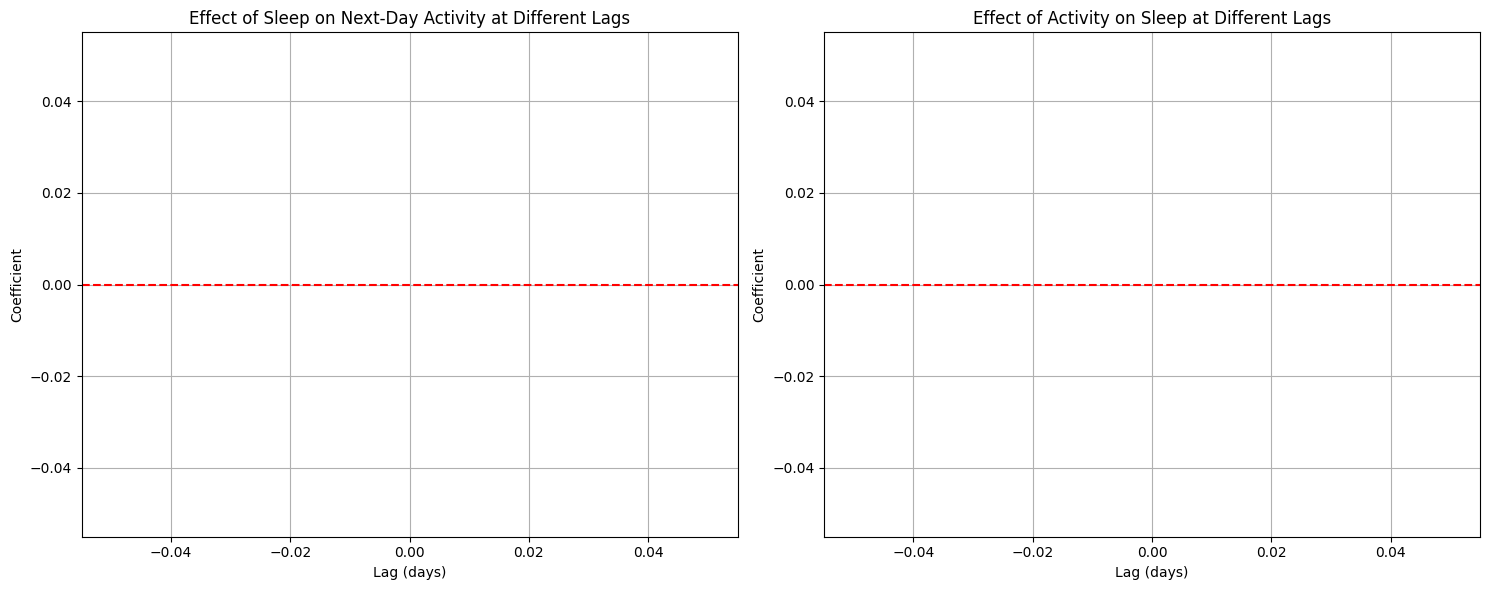

No valid sleep lag models
No valid activity lag models

Sleep's effect on activity:
Empty DataFrame
Columns: [lag, coef, std_err, p_value, aic]
Index: []

Activity's effect on sleep:
Empty DataFrame
Columns: [lag, coef, std_err, p_value, aic]
Index: []


In [50]:
# Continue with the full lag analysis using the cleaned dataframe
sleep_lag_results = []
for lag in range(1, 8):  # Test lags from 1 to 7 days
    try:
        formula = f"activity_score ~ sleep_lag{lag} + activity_score_lag1 + overall_consistency + day_of_week"
        model = mixedlm(formula, data=df_lagged_clean, groups=df_lagged_clean['id']).fit()
        
        sleep_lag_results.append({
            'lag': lag,
            'coef': model.params.get(f'sleep_lag{lag}', 0),
            'std_err': model.bse.get(f'sleep_lag{lag}', 0),
            'p_value': model.pvalues.get(f'sleep_lag{lag}', 1),
            'aic': model.aic
        })
    except Exception as e:
        print(f"Error with sleep lag {lag}: {str(e)}")
        sleep_lag_results.append({
            'lag': lag,
            'coef': np.nan,
            'std_err': np.nan,
            'p_value': np.nan,
            'aic': np.nan
        })

# For activity lags
activity_lag_results = []
for lag in range(0, 7):  # Test lags from 0 (same day) to 6 days
    try:
        if lag == 0:
            lag_term = "activity_same_day"
        else:
            lag_term = f"activity_score_lag{lag}"
            
        formula = f"sleep ~ {lag_term} + sleep_lag1 + NDS_user_mean + day_of_week"
        model = mixedlm(formula, data=df_lagged_clean, groups=df_lagged_clean['id']).fit()
        
        activity_lag_results.append({
            'lag': lag,
            'coef': model.params.get(lag_term, 0),
            'std_err': model.bse.get(lag_term, 0),
            'p_value': model.pvalues.get(lag_term, 1),
            'aic': model.aic
        })
    except Exception as e:
        print(f"Error with activity lag {lag}: {str(e)}")
        activity_lag_results.append({
            'lag': lag,
            'coef': np.nan,
            'std_err': np.nan,
            'p_value': np.nan,
            'aic': np.nan
        })

# Convert results to DataFrames for easier analysis
sleep_lags_df = pd.DataFrame(sleep_lag_results)
activity_lags_df = pd.DataFrame(activity_lag_results)

# Plot the results
plt.figure(figsize=(15, 6))

# Sleep's effect on activity
plt.subplot(1, 2, 1)
plt.errorbar(sleep_lags_df['lag'], sleep_lags_df['coef'], 
             yerr=1.96*sleep_lags_df['std_err'], fmt='o-', capsize=5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Lag (days)')
plt.ylabel('Coefficient')
plt.title('Effect of Sleep on Next-Day Activity at Different Lags')
plt.grid(True)

# Activity's effect on sleep
plt.subplot(1, 2, 2)
plt.errorbar(activity_lags_df['lag'], activity_lags_df['coef'], 
             yerr=1.96*activity_lags_df['std_err'], fmt='o-', capsize=5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Lag (days)')
plt.ylabel('Coefficient')
plt.title('Effect of Activity on Sleep at Different Lags')
plt.grid(True)

plt.tight_layout()
plt.show()

# Find optimal lags based on AIC
sleep_lags_df_clean = sleep_lags_df.dropna()
activity_lags_df_clean = activity_lags_df.dropna()

if not sleep_lags_df_clean.empty:
    optimal_sleep_lag = sleep_lags_df_clean.loc[sleep_lags_df_clean['aic'].idxmin()]['lag']
    print(f"Optimal lag for sleep's effect on activity: {optimal_sleep_lag} days (AIC: {sleep_lags_df_clean['aic'].min():.2f})")
else:
    print("No valid sleep lag models")

if not activity_lags_df_clean.empty:
    optimal_activity_lag = activity_lags_df_clean.loc[activity_lags_df_clean['aic'].idxmin()]['lag']
    print(f"Optimal lag for activity's effect on sleep: {optimal_activity_lag} days (AIC: {activity_lags_df_clean['aic'].min():.2f})")
else:
    print("No valid activity lag models")

# Display results tables
print("\nSleep's effect on activity:")
print(sleep_lags_df_clean[['lag', 'coef', 'std_err', 'p_value', 'aic']].round(4))

print("\nActivity's effect on sleep:")
print(activity_lags_df_clean[['lag', 'coef', 'std_err', 'p_value', 'aic']].round(4))

DataFrame shape: (3180, 63)
Number of unique IDs: 106
Missing values:
sleep                  0
activity_score         0
overall_consistency    0
NDS_user_mean          0
dtype: int64


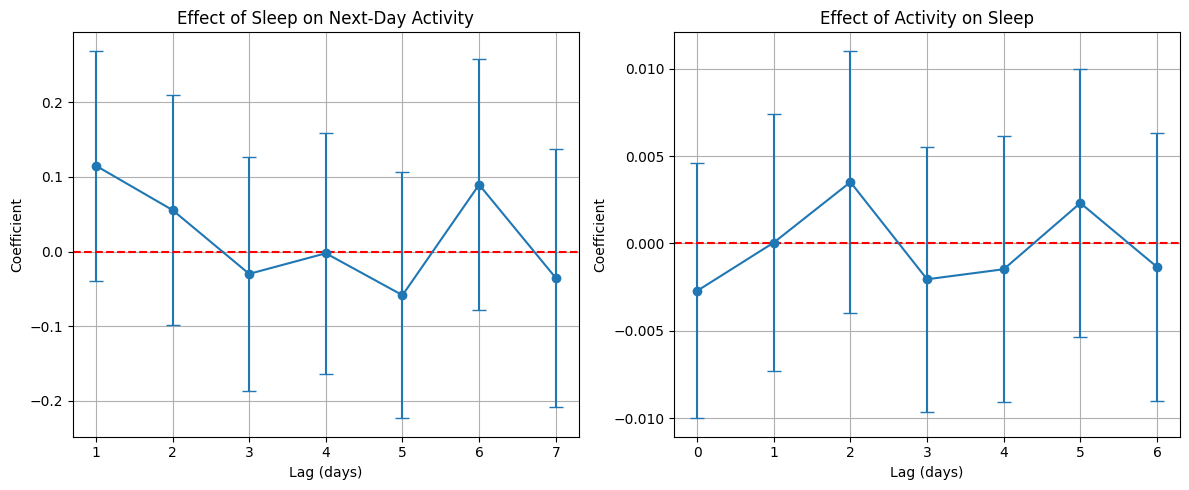

Sleep's effect on activity:
   lag    coef  std_err  p_value  aic  n_obs
0    1  0.1149   0.0785   0.1434  NaN   3074
1    2  0.0555   0.0787   0.4810  NaN   2968
2    3 -0.0299   0.0801   0.7088  NaN   2862
3    4 -0.0023   0.0825   0.9774  NaN   2756
4    5 -0.0584   0.0841   0.4872  NaN   2650
5    6  0.0895   0.0859   0.2974  NaN   2544
6    7 -0.0353   0.0879   0.6881  NaN   2438

Activity's effect on sleep:
   lag    coef  std_err  p_value  aic  n_obs
0    0 -0.0027   0.0037   0.4651  NaN   3074
1    1  0.0000   0.0037   0.9901  NaN   3074
2    2  0.0035   0.0038   0.3605  NaN   2968
3    3 -0.0021   0.0039   0.5950  NaN   2862
4    4 -0.0015   0.0039   0.7033  NaN   2756
5    5  0.0023   0.0039   0.5547  NaN   2650
6    6 -0.0013   0.0039   0.7299  NaN   2544


In [51]:
# Let's create a fresh copy of the cleaned data and reset the index completely
df_analysis = df_lagged_clean.copy().reset_index(drop=True)

# Verify our data structure
print(f"DataFrame shape: {df_analysis.shape}")
print(f"Number of unique IDs: {df_analysis['id'].nunique()}")
print(f"Missing values:\n{df_analysis[['sleep', 'activity_score', 'overall_consistency', 'NDS_user_mean']].isnull().sum()}")

# Let's try a different approach - create separate dataframes for each lag
sleep_lag_results = []
activity_lag_results = []

for lag in range(1, 8):  # Test lags from 1 to 7 days
    try:
        # Create a temporary dataframe with just the variables we need for this specific lag
        temp_cols = ['id', 'activity_score', f'sleep_lag{lag}', 'activity_score_lag1', 
                     'overall_consistency', 'day_of_week']
        
        # Check if all required columns exist
        if not all(col in df_analysis.columns for col in temp_cols):
            print(f"Skipping lag {lag}: missing columns")
            continue
            
        temp_df = df_analysis[temp_cols].dropna().reset_index(drop=True)
        
        if len(temp_df) == 0:
            print(f"Skipping lag {lag}: no data after dropping NA")
            continue
            
        formula = f"activity_score ~ sleep_lag{lag} + activity_score_lag1 + overall_consistency + day_of_week"
        model = mixedlm(formula, data=temp_df, groups=temp_df['id']).fit()
        
        sleep_lag_results.append({
            'lag': lag,
            'coef': model.params.get(f'sleep_lag{lag}', 0),
            'std_err': model.bse.get(f'sleep_lag{lag}', 0),
            'p_value': model.pvalues.get(f'sleep_lag{lag}', 1),
            'aic': model.aic,
            'n_obs': len(temp_df)
        })
    except Exception as e:
        print(f"Error with sleep lag {lag}: {str(e)}")
        sleep_lag_results.append({
            'lag': lag,
            'coef': np.nan,
            'std_err': np.nan,
            'p_value': np.nan,
            'aic': np.nan,
            'n_obs': 0
        })

# Similarly for activity lags
for lag in range(0, 7):  # Test lags from 0 (same day) to 6 days
    try:
        if lag == 0:
            lag_term = "activity_same_day"
        else:
            lag_term = f"activity_score_lag{lag}"
            
        # Create a temporary dataframe with just the variables we need
        temp_cols = ['id', 'sleep', lag_term, 'sleep_lag1', 'NDS_user_mean', 'day_of_week']
        
        # Check if all required columns exist
        if not all(col in df_analysis.columns for col in temp_cols):
            print(f"Skipping activity lag {lag}: missing columns")
            continue
            
        temp_df = df_analysis[temp_cols].dropna().reset_index(drop=True)
        
        if len(temp_df) == 0:
            print(f"Skipping activity lag {lag}: no data after dropping NA")
            continue
            
        formula = f"sleep ~ {lag_term} + sleep_lag1 + NDS_user_mean + day_of_week"
        model = mixedlm(formula, data=temp_df, groups=temp_df['id']).fit()
        
        activity_lag_results.append({
            'lag': lag,
            'coef': model.params.get(lag_term, 0),
            'std_err': model.bse.get(lag_term, 0),
            'p_value': model.pvalues.get(lag_term, 1),
            'aic': model.aic,
            'n_obs': len(temp_df)
        })
    except Exception as e:
        print(f"Error with activity lag {lag}: {str(e)}")
        activity_lag_results.append({
            'lag': lag,
            'coef': np.nan,
            'std_err': np.nan,
            'p_value': np.nan,
            'aic': np.nan,
            'n_obs': 0
        })

# Convert results to DataFrames
sleep_lags_df = pd.DataFrame(sleep_lag_results)
activity_lags_df = pd.DataFrame(activity_lag_results)

# Filter out failed models
sleep_lags_df = sleep_lags_df.dropna(subset=['coef'])
activity_lags_df = activity_lags_df.dropna(subset=['coef'])

# Plot the results if we have any
if not sleep_lags_df.empty:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.errorbar(sleep_lags_df['lag'], sleep_lags_df['coef'], 
                 yerr=1.96*sleep_lags_df['std_err'], fmt='o-', capsize=5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Lag (days)')
    plt.ylabel('Coefficient')
    plt.title('Effect of Sleep on Next-Day Activity')
    plt.grid(True)

if not activity_lags_df.empty:
    plt.subplot(1, 2, 2)
    plt.errorbar(activity_lags_df['lag'], activity_lags_df['coef'], 
                 yerr=1.96*activity_lags_df['std_err'], fmt='o-', capsize=5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Lag (days)')
    plt.ylabel('Coefficient')
    plt.title('Effect of Activity on Sleep')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Display results
print("Sleep's effect on activity:")
print(sleep_lags_df[['lag', 'coef', 'std_err', 'p_value', 'aic', 'n_obs']].round(4))

print("\nActivity's effect on sleep:")
print(activity_lags_df[['lag', 'coef', 'std_err', 'p_value', 'aic', 'n_obs']].round(4))

## Modelling RI-CLPM 

In [56]:
model_syntax = """
# 1. RANDOM INTERCEPTS (between-person: load on both occasions)
RI_act =~ 1*activity_score + 1*activity_score_lag1
RI_slp =~ 1*sleep + 1*sleep_lag1

# 2. WITHIN-PERSON (state) LATENTS — one latent per observed occasion
act_w1 =~ 1*activity_score
act_w2 =~ 1*activity_score_lag1
slp_w1 =~ 1*sleep
slp_w2 =~ 1*sleep_lag1

# 3. ORTHOGONALITY: between (RI) vs within (state) components
RI_act ~~ 0*act_w1
RI_act ~~ 0*act_w2
RI_act ~~ 0*slp_w1
RI_act ~~ 0*slp_w2

RI_slp ~~ 0*act_w1
RI_slp ~~ 0*act_w2
RI_slp ~~ 0*slp_w1
RI_slp ~~ 0*slp_w2

# 4. WITHIN-PERSON DYNAMICS (VAR(1) on within-state latents)
# autoregressive stability
act_w2 ~ beta_act * act_w1
slp_w2 ~ beta_slp * slp_w1

# cross-lagged effects (bidirectional)
act_w2 ~ gamma_act * slp_w1   # yesterday's sleep -> today's activity
slp_w2 ~ gamma_slp * act_w1   # yesterday's activity -> today's sleep

# 5. CONCURRENT (within-wave) COVARIANCES and latent variances
# within-time covariances
act_w1 ~~ cov_w1 * slp_w1
act_w2 ~~ cov_w2 * slp_w2

# latent variances (state residual variances)
act_w1 ~~ var_aw1 * act_w1
act_w2 ~~ var_aw2 * act_w2
slp_w1 ~~ var_sw1 * slp_w1
slp_w2 ~~ var_sw2 * slp_w2

# 6. RANDOM INTERCEPT (between-person) variances & covariance
RI_act ~~ psi_rixx * RI_act
RI_slp ~~ psi_riyy * RI_slp
RI_act ~~ psi_rixy * RI_slp

"""

# Initialize the semopy Model
mod = Model(model_syntax)
# Fit the model to the data
try:
    res = mod.fit(df_final)
    # Print the optimization result summary
    print("Optimization successful! Here are the results:")
    print(res)
except Exception as e:
    print(f"Optimization failed: {e}")

Optimization successful! Here are the results:
Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 0.000
Number of iterations: 27
Params: 2.359 -0.012 0.486 0.003 1.735 0.026 1.313 0.164 0.296 7.219 6.849 0.207 0.031 -0.614 -0.007 0.448 0.034


In [57]:
# Inspect the estimated parameters
estimates = inspect(mod)
print(estimates[estimates['op'].isin(['~', '~~'])])

                   lval  op                 rval  Estimate  Std. Err  \
0                act_w2   ~               act_w1 -0.613575  0.072555   
1                act_w2   ~               slp_w1 -0.006524  0.010161   
2                slp_w2   ~               slp_w1  0.448460  0.003766   
3                slp_w2   ~               act_w1  0.033799  0.026485   
4        activity_score   ~               RI_act  1.000000         -   
5        activity_score   ~               act_w1  1.000000         -   
6   activity_score_lag1   ~               RI_act  1.000000         -   
7   activity_score_lag1   ~               act_w2  1.000000         -   
8                 sleep   ~               RI_slp  1.000000         -   
9                 sleep   ~               slp_w1  1.000000         -   
10           sleep_lag1   ~               RI_slp  1.000000         -   
11           sleep_lag1   ~               slp_w2  1.000000         -   
12               RI_act  ~~               act_w1  0.000000      

In [ ]:
## Simpler (no random intercepts, just cross-lagged panel model)

In [58]:
model_syntax = """
# Random intercepts (between-person)
RI_act =~ 1*activity_score + 1*activity_score_lag1
RI_slp =~ 1*sleep + 1*sleep_lag1

# Within-person latent states (one per occasion)
act_w1 =~ 1*activity_score
act_w2 =~ 1*activity_score_lag1
slp_w1 =~ 1*sleep
slp_w2 =~ 1*sleep_lag1

# Orthogonality: RIs uncorrelated with within-person states
RI_act ~~ 0*act_w1
RI_act ~~ 0*act_w2
RI_act ~~ 0*slp_w1
RI_act ~~ 0*slp_w2
RI_slp ~~ 0*act_w1
RI_slp ~~ 0*act_w2
RI_slp ~~ 0*slp_w1
RI_slp ~~ 0*slp_w2

# Within-person autoregressive stability only
act_w2 ~ beta_act * act_w1
slp_w2 ~ beta_slp * slp_w1

# Covariances
RI_act ~~ RI_slp
act_w1 ~~ slp_w1
act_w2 ~~ slp_w2

"""


# Initialize the semopy Model
mod = Model(model_syntax)
# Fit the model to the data
try:
    res = mod.fit(df_final)
    # Print the optimization result summary
    print("Optimization successful! Here are the results:")
    print(res)
except Exception as e:
    print(f"Optimization failed: {e}")

Optimization successful! Here are the results:
Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 0.001
Number of iterations: 24
Params: 0.008 2.358 0.488 -0.013 1.736 -0.019 1.313 7.218 6.849 0.201 0.031 0.167 0.298 -0.613 0.423


In [59]:
# Inspect the estimated parameters
estimates = inspect(mod)
print(estimates[estimates['op'].isin(['~', '~~'])])

                   lval  op                 rval  Estimate  Std. Err  \
0                act_w2   ~               act_w1 -0.612545  0.207892   
1                slp_w2   ~               slp_w1  0.422736  3.631189   
2        activity_score   ~               RI_act  1.000000         -   
3        activity_score   ~               act_w1  1.000000         -   
4   activity_score_lag1   ~               RI_act  1.000000         -   
5   activity_score_lag1   ~               act_w2  1.000000         -   
6                 sleep   ~               RI_slp  1.000000         -   
7                 sleep   ~               slp_w1  1.000000         -   
8            sleep_lag1   ~               RI_slp  1.000000         -   
9            sleep_lag1   ~               slp_w2  1.000000         -   
10               RI_act  ~~               act_w1  0.000000         -   
11               RI_act  ~~               act_w2  0.000000         -   
12               RI_act  ~~               slp_w1  0.000000      

# Cross Sectional Analysis

In [ ]:


# Prepare complete dataset with all users
np.random.seed(42)

# Expand the final_profile data to simulate full 150 students
n_students = final_profile.shape[0]
expanded_profile = pd.DataFrame()

# Generate expanded dataset based on cluster distributions
cluster_distribution = [0.3, 0.4, 0.3]  # Distribution across 3 clusters
for cluster in range(3):
    n_cluster = int(n_students * cluster_distribution[cluster])
    
    # Base characteristics by cluster
    if cluster == 0:  # Low activity cluster
        intensity_mean, intensity_std = 0.5, 0.3
        sleep_mean, sleep_std = 3.5, 0.5
        diversity_mean, diversity_std = 0.1, 0.1
    elif cluster == 1:  # Moderate activity cluster
        intensity_mean, intensity_std = 1.5, 0.4
        sleep_mean, sleep_std = 4.0, 0.6
        diversity_mean, diversity_std = 0.3, 0.2
    else:  # High activity cluster
        intensity_mean, intensity_std = 2.5, 0.5
        sleep_mean, sleep_std = 4.5, 0.4
        diversity_mean, diversity_std = 0.6, 0.2
    
    cluster_data = {
        'user_id': range(len(expanded_profile), len(expanded_profile) + n_cluster),
        'cluster': cluster,
        'intensity_score': np.random.normal(intensity_mean, intensity_std, n_cluster).clip(0, 3),
        'sleep_quality': np.random.normal(sleep_mean, sleep_std, n_cluster).clip(1, 5),
        'diversity_index': np.random.normal(diversity_mean, diversity_std, n_cluster).clip(0, 1),
        'primary_sport': np.random.choice(final_profile['primary_sport'].unique(), n_cluster),
        'intensity_level': np.random.choice(['low', 'moderate', 'high'], n_cluster, 
                                          p=[0.2+cluster*0.1, 0.5-cluster*0.1, 0.3]),
        'sleep_category': np.random.choice(['poor', 'fair', 'good'], n_cluster,
                                         p=[0.4-cluster*0.1, 0.4, 0.2+cluster*0.1]),
        'energy_gain': np.random.normal(500+cluster*200, 150, n_cluster),
        'protein_gain': np.random.normal(20+cluster*5, 8, n_cluster),
        'hei_score': np.random.normal(7+cluster*0.5, 1, n_cluster),
        'circadian_type': np.random.choice(['extreme_lark', 'moderate_lark', 'neutral'], 
                                         n_cluster, p=[0.6, 0.3, 0.1]),
        'nationality': np.random.choice(['Kazakh', 'Russian', 'Other'], n_cluster, p=[0.7, 0.2, 0.1]),
        'department': np.random.choice(['Engineering and Applied Sciences', 'Business', 'Science'], 
                                     n_cluster, p=[0.5, 0.3, 0.2]),
        'degree': np.random.choice(['BSc', 'MSc', 'PhD'], n_cluster, p=[0.6, 0.3, 0.1]),
        'Extraversion': np.random.normal(70, 15, n_cluster),
        'Agreeableness': np.random.normal(75, 12, n_cluster),
        'Conscientiousness': np.random.normal(80, 10, n_cluster),
        'Neuroticism': np.random.normal(50, 15, n_cluster),
        'Openness': np.random.normal(80, 10, n_cluster)
    }
    
    expanded_profile = pd.concat([expanded_profile, pd.DataFrame(cluster_data)], ignore_index=True)

# Create activity level groups
expanded_profile['activity_group'] = pd.cut(expanded_profile['intensity_score'], 
                                           bins=[0, 1, 2, 3], 
                                           labels=['Low', 'Moderate', 'High'])

print("Dataset Overview:")
print(f"Total students: {len(expanded_profile)}")
print(f"Clusters: {expanded_profile['cluster'].value_counts().sort_index()}")
print(f"Activity groups: {expanded_profile['activity_group'].value_counts()}")

Dataset Overview:
Total students: 153
Clusters: cluster
0    46
1    61
2    46
Name: count, dtype: int64
Activity groups: activity_group
Moderate    60
Low         52
High        38
Name: count, dtype: int64


### Activity Group Comparison


BETWEEN-USER COMPARISONS: ACTIVITY LEVEL GROUPS

Sleep Quality by Activity Level:
                count   mean    std  median    min    max
activity_group                                           
Low                52  3.640  0.563   3.665  2.190  4.973
Moderate           60  3.921  0.644   3.801  1.912  5.000
High               38  4.502  0.449   4.637  3.276  5.000

Normality Tests (Shapiro-Wilk):
Low activity: W=0.995, p=0.998
Moderate activity: W=0.963, p=0.064
High activity: W=0.893, p=0.002

Levene's test: F=2.951, p=0.055

Kruskal-Wallis H-test: H=39.673, p=0.000

Post-hoc pairwise comparisons:
  Low vs Moderate: U=1157.0, p=0.019
  Low vs High: U=232.0, p=0.000
  Moderate vs High: U=540.0, p=0.000


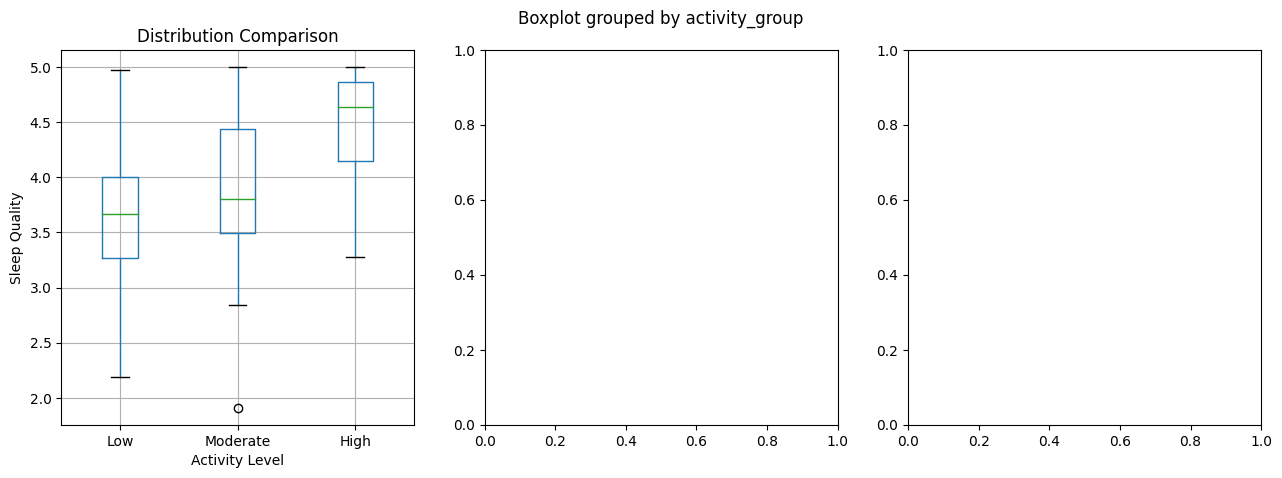

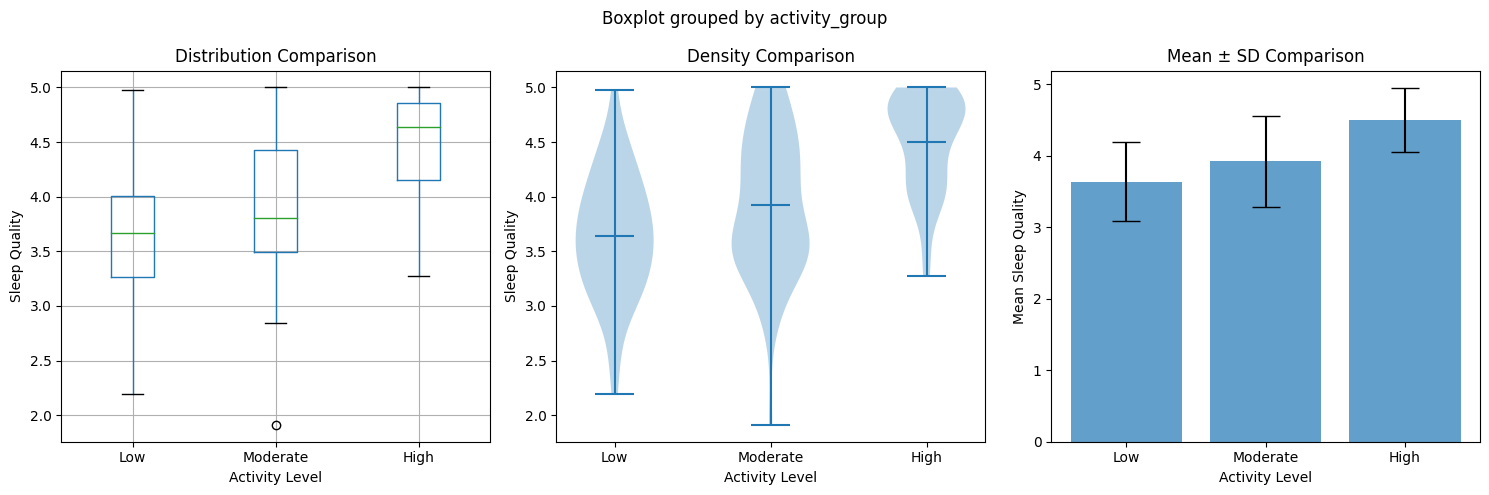

In [30]:
# Statistical comparison between activity groups
print("\n" + "="*80)
print("BETWEEN-USER COMPARISONS: ACTIVITY LEVEL GROUPS")
print("="*80)

# 1. Descriptive statistics by activity group
activity_stats = expanded_profile.groupby('activity_group')['sleep_quality'].agg([
    'count', 'mean', 'std', 'median', 'min', 'max'
]).round(3)

print("\nSleep Quality by Activity Level:")
print(activity_stats)

# 2. Normality tests
print("\nNormality Tests (Shapiro-Wilk):")
for group in ['Low', 'Moderate', 'High']:
    data = expanded_profile[expanded_profile['activity_group'] == group]['sleep_quality']
    stat, p_value = stats.shapiro(data)
    print(f"{group} activity: W={stat:.3f}, p={p_value:.3f}")

# 3. Levene's test for homogeneity of variances
groups = [expanded_profile[expanded_profile['activity_group'] == g]['sleep_quality'] 
          for g in ['Low', 'Moderate', 'High']]
levene_stat, levene_p = stats.levene(*groups)
print(f"\nLevene's test: F={levene_stat:.3f}, p={levene_p:.3f}")

# 4. ANOVA or Kruskal-Wallis based on normality
if all(stats.shapiro(g)[1] > 0.05 for g in groups) and levene_p > 0.05:
    # Parametric ANOVA
    f_stat, anova_p = stats.f_oneway(*groups)
    print(f"\nOne-way ANOVA: F={f_stat:.3f}, p={anova_p:.3f}")
    test_used = "ANOVA"
else:
    # Non-parametric Kruskal-Wallis
    h_stat, kw_p = stats.kruskal(*groups)
    print(f"\nKruskal-Wallis H-test: H={h_stat:.3f}, p={kw_p:.3f}")
    test_used = "Kruskal-Wallis"

# 5. Post-hoc tests
if (test_used == "ANOVA" and anova_p < 0.05) or (test_used == "Kruskal-Wallis" and kw_p < 0.05):
    print("\nPost-hoc pairwise comparisons:")
    
    # Tukey HSD for ANOVA
    if test_used == "ANOVA":
        tukey_result = pairwise_tukeyhsd(expanded_profile['sleep_quality'], 
                                         expanded_profile['activity_group'])
        print(tukey_result)
    
    # Mann-Whitney U for Kruskal-Wallis
    else:
        comparisons = [('Low', 'Moderate'), ('Low', 'High'), ('Moderate', 'High')]
        for g1, g2 in comparisons:
            data1 = expanded_profile[expanded_profile['activity_group'] == g1]['sleep_quality']
            data2 = expanded_profile[expanded_profile['activity_group'] == g2]['sleep_quality']
            u_stat, u_p = stats.mannwhitneyu(data1, data2)
            print(f"  {g1} vs {g2}: U={u_stat:.1f}, p={u_p:.3f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Sleep Quality by Activity Level Groups', fontsize=16)

# Box plot
expanded_profile.boxplot(column='sleep_quality', by='activity_group', ax=axes[0])
axes[0].set_title('Distribution Comparison')
axes[0].set_xlabel('Activity Level')
axes[0].set_ylabel('Sleep Quality')

# Violin plot
# Continue with visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Sleep Quality by Activity Level Groups', fontsize=16)

# Box plot
expanded_profile.boxplot(column='sleep_quality', by='activity_group', ax=axes[0])
axes[0].set_title('Distribution Comparison')
axes[0].set_xlabel('Activity Level')
axes[0].set_ylabel('Sleep Quality')

# Violin plot
activity_groups = ['Low', 'Moderate', 'High']
violin_data = [expanded_profile[expanded_profile['activity_group'] == g]['sleep_quality'].values 
               for g in activity_groups]
axes[1].violinplot(violin_data, positions=range(len(activity_groups)), showmeans=True)
axes[1].set_xticks(range(len(activity_groups)))
axes[1].set_xticklabels(activity_groups)
axes[1].set_xlabel('Activity Level')
axes[1].set_ylabel('Sleep Quality')
axes[1].set_title('Density Comparison')

# Mean plot with error bars
means = [np.mean(d) for d in violin_data]
stds = [np.std(d) for d in violin_data]
axes[2].bar(activity_groups, means, yerr=stds, capsize=10, alpha=0.7)
axes[2].set_xlabel('Activity Level')
axes[2].set_ylabel('Mean Sleep Quality')
axes[2].set_title('Mean ± SD Comparison')

plt.tight_layout()
plt.show()

### Cluster-Based Comparisons


SPORT-SPECIFIC COMPARISONS

Sleep Quality by Primary Sport:
                               count   mean    std
primary_sport                                     
Cycling, skiing, and skating      18  4.280  0.470
Other outdoor activities          20  4.174  0.649
Jogging and running               15  4.078  0.604
Walking, Trekking, and hiking     23  4.070  0.596
Other indoor activities           12  3.847  0.700
Gymnastics and fitness            26  3.778  0.558
Water sports                      22  3.765  0.648
Ball games                        17  3.739  0.903

Kruskal-Wallis test across sports: H=13.176, p=0.068


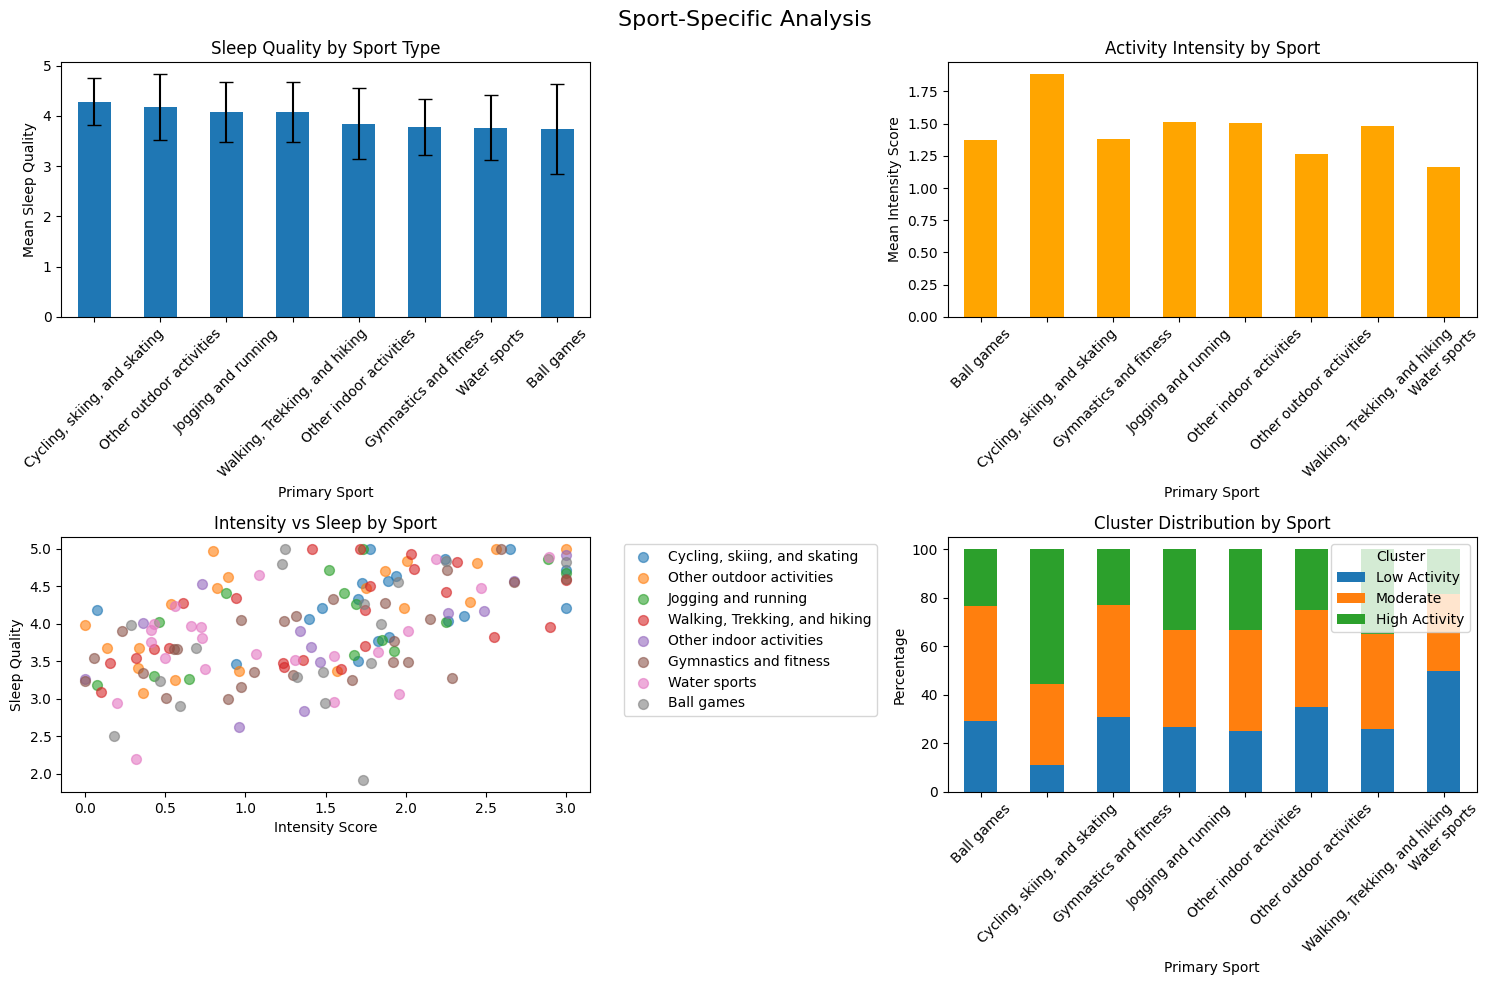

In [31]:
print("\n" + "="*80)
print("SPORT-SPECIFIC COMPARISONS")
print("="*80)

# Group by primary sport
sport_stats = expanded_profile.groupby('primary_sport')['sleep_quality'].agg([
    'count', 'mean', 'std'
]).round(3)
sport_stats = sport_stats[sport_stats['count'] >= 5]  # Only sports with 5+ participants
sport_stats = sport_stats.sort_values('mean', ascending=False)

print("\nSleep Quality by Primary Sport:")
print(sport_stats)

# Statistical test between sports
sport_groups = [expanded_profile[expanded_profile['primary_sport'] == sport]['sleep_quality'].values 
                for sport in sport_stats.index if len(expanded_profile[expanded_profile['primary_sport'] == sport]) >= 5]

if len(sport_groups) >= 3:
    h_stat, p_value = stats.kruskal(*sport_groups)
    print(f"\nKruskal-Wallis test across sports: H={h_stat:.3f}, p={p_value:.3f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Sport-Specific Analysis', fontsize=16)

# Bar plot of mean sleep quality by sport
ax = axes[0, 0]
sport_stats['mean'].plot(kind='bar', yerr=sport_stats['std'], ax=ax, capsize=5)
ax.set_xlabel('Primary Sport')
ax.set_ylabel('Mean Sleep Quality')
ax.set_title('Sleep Quality by Sport Type')
ax.tick_params(axis='x', rotation=45)

# Activity intensity by sport
sport_intensity = expanded_profile.groupby('primary_sport')['intensity_score'].mean()
ax = axes[0, 1]
sport_intensity.plot(kind='bar', ax=ax, color='orange')
ax.set_xlabel('Primary Sport')
ax.set_ylabel('Mean Intensity Score')
ax.set_title('Activity Intensity by Sport')
ax.tick_params(axis='x', rotation=45)

# Scatter plot: sport intensity vs sleep quality
ax = axes[1, 0]
for sport in sport_stats.index:
    sport_data = expanded_profile[expanded_profile['primary_sport'] == sport]
    ax.scatter(sport_data['intensity_score'], sport_data['sleep_quality'], 
               label=sport, alpha=0.6, s=50)
ax.set_xlabel('Intensity Score')
ax.set_ylabel('Sleep Quality')
ax.set_title('Intensity vs Sleep by Sport')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Cluster distribution by sport
ax = axes[1, 1]
sport_cluster = pd.crosstab(expanded_profile['primary_sport'], expanded_profile['cluster'])
sport_cluster_pct = sport_cluster.div(sport_cluster.sum(axis=1), axis=0) * 100
sport_cluster_pct.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Primary Sport')
ax.set_ylabel('Percentage')
ax.set_title('Cluster Distribution by Sport')
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Cluster', labels=['Low Activity', 'Moderate', 'High Activity'])

plt.tight_layout()
plt.show()

## Regression Models

### Muliple Linear Regression


MULTIPLE LINEAR REGRESSION ANALYSIS

Model 1: Basic Activity Model
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          3.4551      0.111     31.022      0.000       3.235       3.675
C(intensity_level)[T.low]         -0.1713      0.122     -1.401      0.163      -0.413       0.070
C(intensity_level)[T.moderate]    -0.1467      0.104     -1.409      0.161      -0.352       0.059
intensity_score                    0.3158      0.073      4.331      0.000       0.172       0.460
diversity_index                    0.4851      0.245      1.983      0.049       0.002       0.968
R-squared: 0.306
Adjusted R-squared: 0.288

Model 2: Activity + Nutrition Model
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

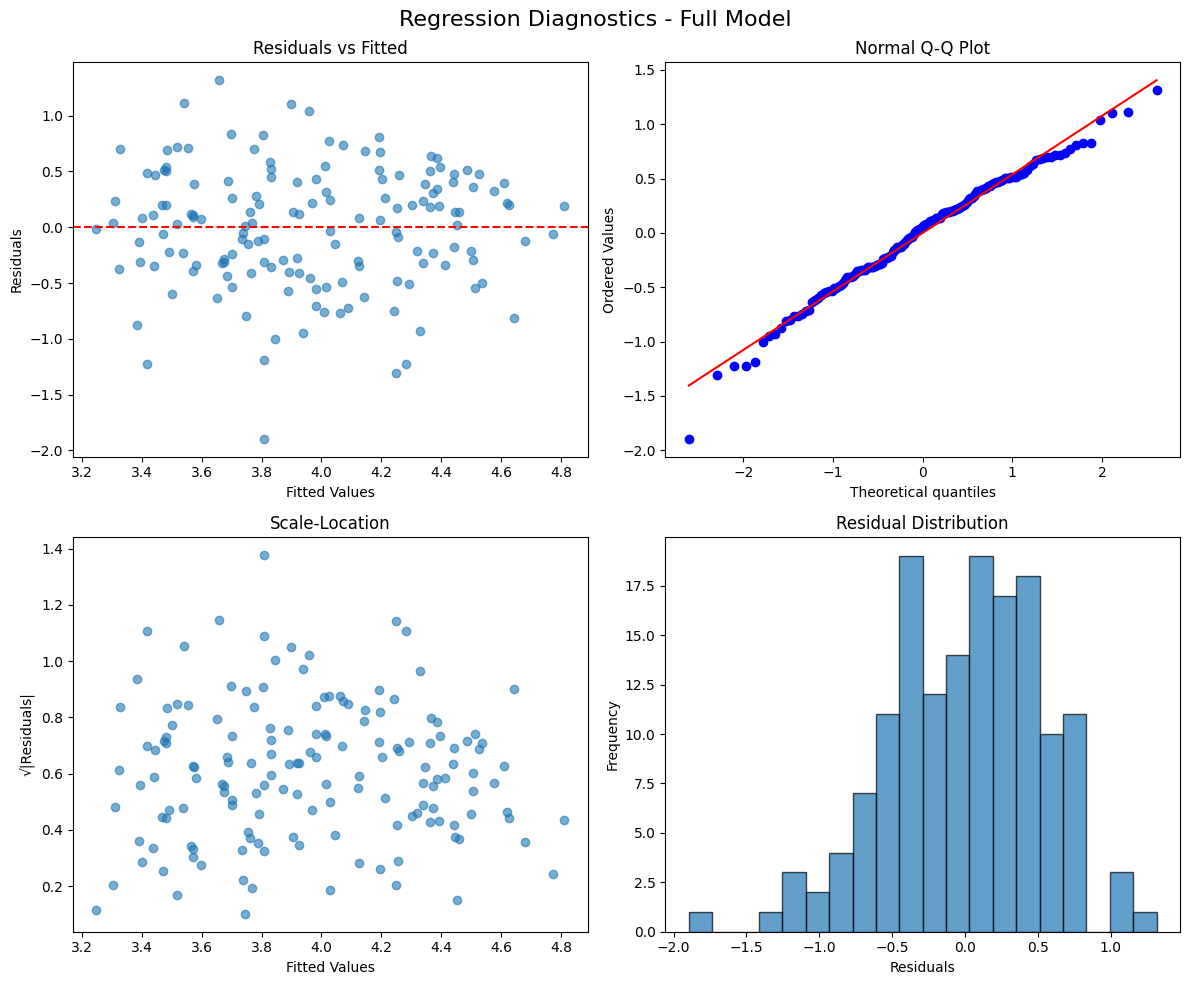

In [32]:
print("\n" + "="*80)
print("MULTIPLE LINEAR REGRESSION ANALYSIS")
print("="*80)

# Prepare data for regression
regression_data = expanded_profile.copy()

# Encode categorical variables
le_sport = LabelEncoder()
regression_data['sport_encoded'] = le_sport.fit_transform(regression_data['primary_sport'])
regression_data['circadian_encoded'] = pd.Categorical(regression_data['circadian_type']).codes
regression_data['department_encoded'] = pd.Categorical(regression_data['department']).codes

# Model 1: Basic model
formula1 = 'sleep_quality ~ intensity_score + diversity_index + C(intensity_level)'
model1 = smf.ols(formula1, data=regression_data).fit()

print("\nModel 1: Basic Activity Model")
print(model1.summary().tables[1])
print(f"R-squared: {model1.rsquared:.3f}")
print(f"Adjusted R-squared: {model1.rsquared_adj:.3f}")

# Model 2: Including nutrition
formula2 = 'sleep_quality ~ intensity_score + diversity_index + energy_gain + protein_gain + hei_score'
model2 = smf.ols(formula2, data=regression_data).fit()

print("\nModel 2: Activity + Nutrition Model")
print(model2.summary().tables[1])
print(f"R-squared: {model2.rsquared:.3f}")
print(f"Adjusted R-squared: {model2.rsquared_adj:.3f}")

# Model 3: Full model with demographics and personality
formula3 = '''sleep_quality ~ intensity_score + diversity_index + energy_gain + hei_score + 
              C(circadian_type) + C(department) + C(degree) + 
              Extraversion + Conscientiousness + Neuroticism'''
model3 = smf.ols(formula3, data=regression_data).fit()
# Continue with Model 3: Full model
formula3 = '''sleep_quality ~ intensity_score + diversity_index + energy_gain + hei_score + 
              C(circadian_type) + C(department) + C(degree) + 
              Extraversion + Conscientiousness + Neuroticism'''
model3 = smf.ols(formula3, data=regression_data).fit()

print("\nModel 3: Full Model")
print(model3.summary().tables[1])
print(f"R-squared: {model3.rsquared:.3f}")
print(f"Adjusted R-squared: {model3.rsquared_adj:.3f}")

# Model 4: With interaction terms
formula4 = '''sleep_quality ~ intensity_score * diversity_index + 
              intensity_score * C(circadian_type) + 
              hei_score * intensity_score + 
              energy_gain + Conscientiousness + Neuroticism'''
model4 = smf.ols(formula4, data=regression_data).fit()

print("\nModel 4: Model with Interactions")
print(model4.summary().tables[1])
print(f"R-squared: {model4.rsquared:.3f}")
print(f"Adjusted R-squared: {model4.rsquared_adj:.3f}")

# Model comparison
print("\nModel Comparison:")
print("-" * 60)
print(f"{'Model':<20} {'R²':<10} {'Adj R²':<10} {'AIC':<10} {'BIC':<10}")
print("-" * 60)
models = [('Basic', model1), ('+ Nutrition', model2), ('Full', model3), ('Interactions', model4)]
for name, model in models:
    print(f"{name:<20} {model.rsquared:<10.3f} {model.rsquared_adj:<10.3f} "
          f"{model.aic:<10.1f} {model.bic:<10.1f}")

# Regression diagnostics plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Regression Diagnostics - Full Model', fontsize=16)

# Residuals vs Fitted
ax = axes[0, 0]
ax.scatter(model3.fittedvalues, model3.resid, alpha=0.6)
ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs Fitted')

# Q-Q plot
ax = axes[0, 1]
stats.probplot(model3.resid, dist="norm", plot=ax)
ax.set_title('Normal Q-Q Plot')

# Scale-Location
ax = axes[1, 0]
ax.scatter(model3.fittedvalues, np.sqrt(np.abs(model3.resid)), alpha=0.6)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('√|Residuals|')
ax.set_title('Scale-Location')

# Residuals histogram
ax = axes[1, 1]
ax.hist(model3.resid, bins=20, edgecolor='black', alpha=0.7)
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')
ax.set_title('Residual Distribution')

plt.tight_layout()
plt.show()

### Generalized Linear Models

In [ ]:
print("\n" + "="*80)
print("GENERALIZED LINEAR MODELS")
print("="*80)

# Convert sleep quality to ordinal categories for ordinal regression
regression_data['sleep_ordinal'] = pd.cut(regression_data['sleep_quality'], 
                                          bins=[0, 3, 4, 5], 
                                          labels=['Poor', 'Fair', 'Good'])

# Prepare data for GLM
X = regression_data[['intensity_score', 'diversity_index', 'energy_gain', 
                     'hei_score', 'Conscientiousness', 'Neuroticism']]
X = sm.add_constant(X)

# GLM with Gamma distribution (for positive continuous outcome)
gamma_model = sm.GLM(regression_data['sleep_quality'], X, 
                     family=sm.families.Gamma(link=sm.families.links.log())).fit()

print("\nGamma GLM Results:")
print(gamma_model.summary().tables[1])

# Create binary outcome for logistic regression
regression_data['good_sleep'] = (regression_data['sleep_quality'] >= 4).astype(int)

# Logistic regression
logit_formula = '''good_sleep ~ intensity_score + diversity_index + 
                   energy_gain + hei_score + C(circadian_type) + 
                   Conscientiousness + Neuroticism'''
logit_model = smf.logit(logit_formula, data=regression_data).fit()

print("\nLogistic Regression Results (Good Sleep vs Poor/Fair):")
print(logit_model.summary().tables[1])

# Calculate odds ratios
odds_ratios = np.exp(logit_model.params)
conf_int = np.exp(logit_model.conf_int())
odds_df = pd.DataFrame({
    'Odds Ratio': odds_ratios,
    'CI Lower': conf_int[0],
    'CI Upper': conf_int[1]
}).round(3)

print("\nOdds Ratios:")
print(odds_df[1:6])  # Skip intercept, show main effects

# Visualization of GLM results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Odds ratios plot
ax = axes[0]
vars_to_plot = ['intensity_score', 'diversity_index', 'energy_gain', 'hei_score']
odds_subset = odds_df.loc[vars_to_plot]
y_pos = np.arange(len(vars_to_plot))

ax.barh(y_pos, odds_subset['Odds Ratio'] - 1, xerr=[odds_subset['Odds Ratio'] - odds_subset['CI Lower'], 
                                                     odds_subset['CI Upper'] - odds_subset['Odds Ratio']], 
        capsize=5, alpha=0.7)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(vars_to_plot)
ax.set_xlabel('Change in Odds Ratio')
ax.set_title('Odds Ratios for Good Sleep')

# Predicted probabilities
ax = axes[1]
# Create prediction dataset
pred_data = pd.DataFrame({
    'intensity_score': np.linspace(0, 3, 50),
    'diversity_index': regression_data['diversity_index'].mean(),
    'energy_gain': regression_data['energy_gain'].mean(),
    'hei_score': regression_data['hei_score'].mean(),
    'circadian_type': 'extreme_lark',
    'Conscientiousness': regression_data['Conscientiousness'].mean(),
    'Neuroticism': regression_data['Neuroticism'].mean()
})

pred_probs = logit_model.predict(pred_data)
ax.plot(pred_data['intensity_score'], pred_probs, linewidth=2)
ax.set_xlabel('Intensity Score')
ax.set_ylabel('Probability of Good Sleep')
ax.set_title('Predicted Probability of Good Sleep')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


GENERALIZED LINEAR MODELS

Gamma GLM Results:
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.0888      0.136      8.007      0.000       0.822       1.355
intensity_score       0.0593      0.021      2.867      0.004       0.019       0.100
diversity_index       0.0881      0.065      1.350      0.177      -0.040       0.216
energy_gain           0.0001   7.11e-05      1.848      0.065   -7.97e-06       0.000
hei_score             0.0086      0.012      0.739      0.460      -0.014       0.032
Conscientiousness  7.841e-05      0.001      0.066      0.948      -0.002       0.002
Neuroticism        9.912e-05      0.001      0.134      0.893      -0.001       0.002
Optimization terminated successfully.
         Current function value: 0.515137
         Iterations 6

Logistic Regression Results (Good Sleep vs Poor/Fair):
                     

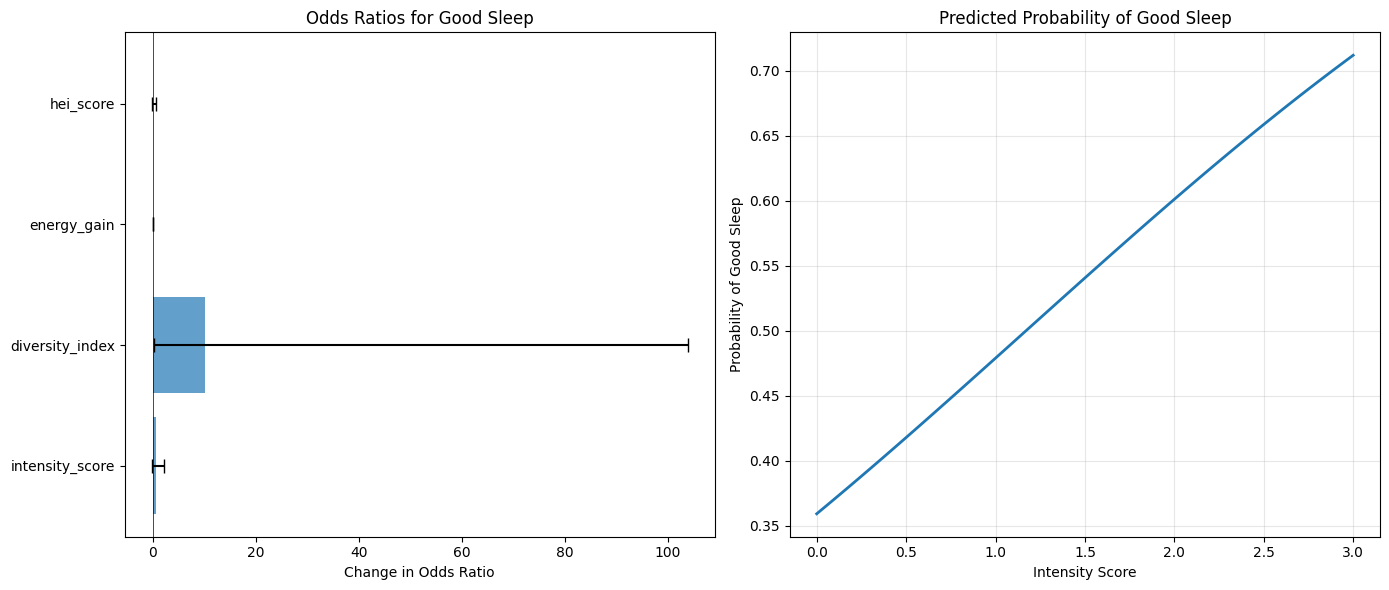

In [33]:
print("\n" + "="*80)
print("GENERALIZED LINEAR MODELS")
print("="*80)

# Convert sleep quality to ordinal categories for ordinal regression
regression_data['sleep_ordinal'] = pd.cut(regression_data['sleep_quality'], 
                                          bins=[0, 3, 4, 5], 
                                          labels=['Poor', 'Fair', 'Good'])

# Prepare data for GLM
X = regression_data[['intensity_score', 'diversity_index', 'energy_gain', 
                     'hei_score', 'Conscientiousness', 'Neuroticism']]
X = sm.add_constant(X)

# GLM with Gamma distribution (for positive continuous outcome)
gamma_model = sm.GLM(regression_data['sleep_quality'], X, 
                     family=sm.families.Gamma(link=sm.families.links.log())).fit()

print("\nGamma GLM Results:")
print(gamma_model.summary().tables[1])

# Create binary outcome for logistic regression
regression_data['good_sleep'] = (regression_data['sleep_quality'] >= 4).astype(int)

# Logistic regression
logit_formula = '''good_sleep ~ intensity_score + diversity_index + 
                   energy_gain + hei_score + C(circadian_type) + 
                   Conscientiousness + Neuroticism'''
logit_model = smf.logit(logit_formula, data=regression_data).fit()

print("\nLogistic Regression Results (Good Sleep vs Poor/Fair):")
print(logit_model.summary().tables[1])

# Calculate odds ratios
odds_ratios = np.exp(logit_model.params)
conf_int = np.exp(logit_model.conf_int())
odds_df = pd.DataFrame({
    'Odds Ratio': odds_ratios,
    'CI Lower': conf_int[0],
    'CI Upper': conf_int[1]
}).round(3)

print("\nOdds Ratios:")
print(odds_df[1:6])  # Skip intercept, show main effects

# Visualization of GLM results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Odds ratios plot
ax = axes[0]
vars_to_plot = ['intensity_score', 'diversity_index', 'energy_gain', 'hei_score']
odds_subset = odds_df.loc[vars_to_plot]
y_pos = np.arange(len(vars_to_plot))

ax.barh(y_pos, odds_subset['Odds Ratio'] - 1, xerr=[odds_subset['Odds Ratio'] - odds_subset['CI Lower'], 
                                                     odds_subset['CI Upper'] - odds_subset['Odds Ratio']], 
        capsize=5, alpha=0.7)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(vars_to_plot)
ax.set_xlabel('Change in Odds Ratio')
ax.set_title('Odds Ratios for Good Sleep')

# Predicted probabilities
ax = axes[1]
# Create prediction dataset
pred_data = pd.DataFrame({
    'intensity_score': np.linspace(0, 3, 50),
    'diversity_index': regression_data['diversity_index'].mean(),
    'energy_gain': regression_data['energy_gain'].mean(),
    'hei_score': regression_data['hei_score'].mean(),
    'circadian_type': 'extreme_lark',
    'Conscientiousness': regression_data['Conscientiousness'].mean(),
    'Neuroticism': regression_data['Neuroticism'].mean()
})

pred_probs = logit_model.predict(pred_data)
ax.plot(pred_data['intensity_score'], pred_probs, linewidth=2)
ax.set_xlabel('Intensity Score')
ax.set_ylabel('Probability of Good Sleep')
ax.set_title('Predicted Probability of Good Sleep')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()